# Burgers and Salads carbon analysis

In [4]:
library(tidyverse)
library(knitr)
options(repr.plot.width=12, repr.plot.height=12)

In [5]:
setwd('/Users/evanmorgan/Documents/Watershed')
col_names = c('Description','Category','Location','Vendor','Unit','factor_source','factor_name','CO2e_per_unit','units_2019','CO2e_kg')

col_spec <- cols_only(Description = col_character(), 
                      Category = col_character(), 
                      Location = col_character(),
                      Vendor = col_character(),
                      Unit = col_character(),
                      factor_source = col_character(),
                      factor_name = col_character(),
                      CO2e_per_unit = col_double(),
                      units_2019 = col_double(),
                      CO2e_kg = col_double())
raw_footprint <- read_csv('burgers_and_salads_footprint.csv', col_names = col_names, col_types = col_spec, skip = 2)

### Approach
Given the carbon equation -- Business Activity * Emissions Factor = CO2e -- we want to look closely at the business activities and emissions factors to ensure they make sense

### Logistics emissions factors
It appears that some logistics emissions factors may be mixed up

For the Dayton store, West Coast Freight has the container ship emissions factor for olive oil\
Meanwhile Flexport has the reefer truck emissions factor for rice

These two should be flipped

### Benchmarks
Let's work with our benchmark information.

We expect an average restaurant's landfill waste to be 2.406 tons per employee\
The San Francisco store has landfill waste of (170000 tons)/(32 employees) = 5312.5 tons per employee\
The Dayton store has landfill waste of (180000 tons) / (30 employees) = 6000 tons per employee\
If the waste measurement for Dayton was actually pounds, our landfill waste would be (90 tons) / (30 employees) = 3 tons per employee\
This is in line with the benchmark, so we'll convert all waste from pounds to tons

We have an energy benchmark that can help us estimate gas usage at the Dayton store\
Dayton energy usage = (0.2230 kwh/sqft) * (4010 sqft) = 894.23 mmBTU\

### Packaging
Packaging is currently reported as a number of boxes; we need box weight to get CO2e in kg

The UN Environment Programme's Life Cycle Initiative measures weight for 200mL PLA containers at 60g = 0.06 kg (https://www.lifecycleinitiative.org/wp-content/uploads/2020/10/Take-Away-food-containers_REPORT_LR.pdf) \
The San Francisco store uses (238000 boxes) * (0.06 kg/box) * (1.88 CO2e/kg) = 26846.4 kg CO2e\
The Dayton store uses (233000 boxes) * (0.06 kg/box) * (1.88 CO2e/kg) = 26282.4 kg CO2e


In [6]:
clean_footprint <- raw_footprint %>% 
  # Change emissions factors for rice and olive oil in Dayton
  mutate(factor_name = case_when(Category == 'Upstream logistics' & Location == 'Dayton' & Description == 'Olive oil' ~ 'transport, freight, lorry with reefer, cooling//[GLO] market for transport, freight, lorry with reefer, cooling',
                                 TRUE ~ factor_name),
         CO2e_per_unit = case_when(Category == 'Upstream logistics' & Location == 'Dayton' & Description == 'Olive oil' ~ 0.12665373,
                                   TRUE ~ CO2e_per_unit)) %>% 
  mutate(factor_name = case_when(Category == 'Upstream logistics' & Location == 'Dayton' & Description == 'Rice' ~ 'transport, freight, sea, container ship//[GLO] market for transport, freight, sea, container ship',
                                 TRUE ~ factor_name),
         CO2e_per_unit = case_when(Category == 'Upstream logistics' & Location == 'Dayton' & Description == 'Rice' ~ 0.009434641,
                                   TRUE ~ CO2e_per_unit)) %>% 
  # Divide waste by 2000 to convert pounds to tons
  mutate(units_2019 = case_when(Category == 'Waste' ~ units_2019/2000,
                                TRUE ~ units_2019)) %>% 
  # Add Dayton natural gas estimate from benchmark
  mutate(units_2019 = case_when(Location == 'Dayton' & Description == 'Restaurant natural gas' ~ 894.23,
                                TRUE ~ units_2019)) %>% 
  # Multiply packaging units by 0.06 to convert boxes to kg PLA
  mutate(units_2019 = case_when(Category == 'Packaging' ~ units_2019*0.06,
                                TRUE ~ units_2019)) %>% 
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

## Showing the curve

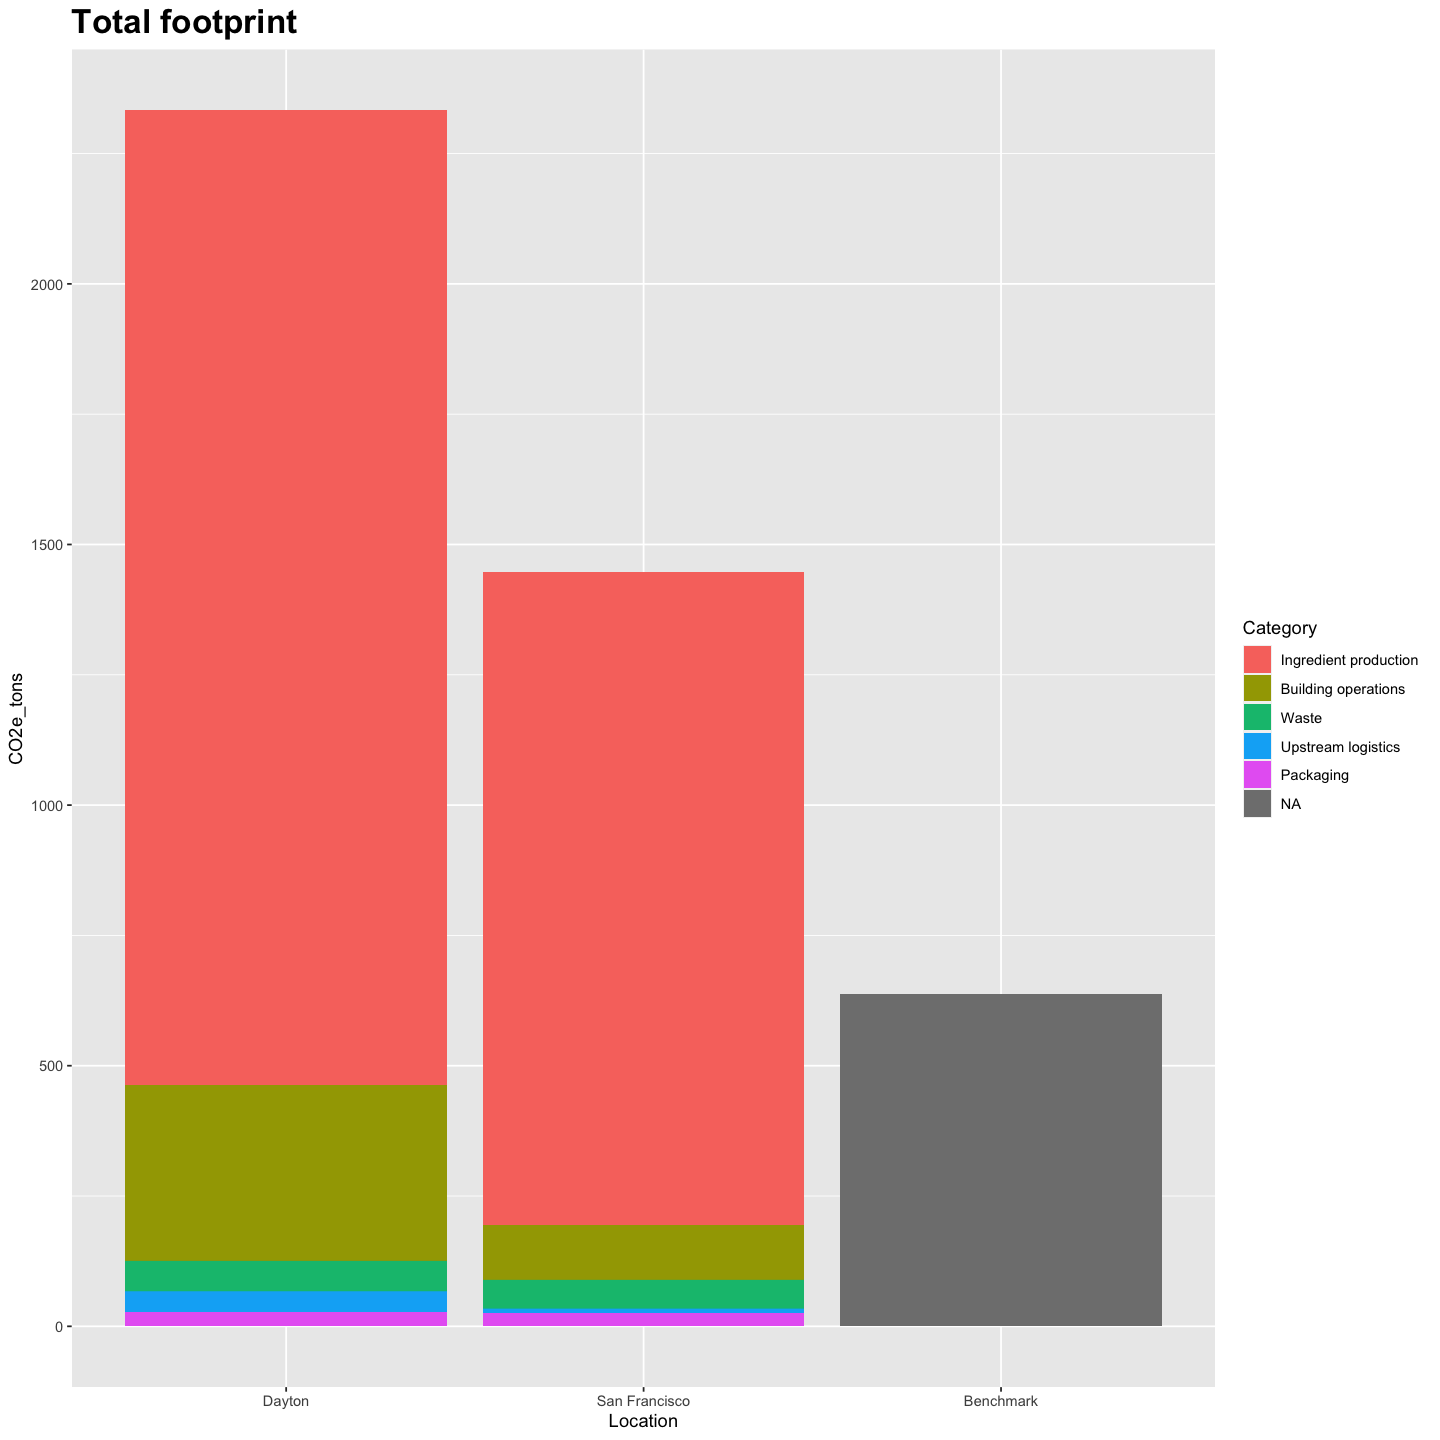

In [7]:
# The benchmark value is Boehm's kg/$ food industry benchmark * our average revenue
benchmark_value <- 0.34*((1750000+2001000)/2)

# Create a benchmark table
benchmark_table <- tribble(~Description,~Category,~Location,~Vendor,~Unit,~factor_source,~factor_name,~CO2e_per_unit,~units_2019,~CO2e_kg,~CO2e_tons,
             NA,NA,'Benchmark','Benchmark',NA,NA,NA,NA,NA,benchmark_value,benchmark_value/1000)

# Create a function to reorder stacked bar chart categories
create_factor <- function(x, levels = c('Ingredient production','Building operations','Waste','Upstream logistics','Packaging')){
  factor(x, levels)
}
column_names <- c('Category')

x_axis_order <- c('Dayton','San Francisco','Benchmark')

total_footprint_chart <- clean_footprint %>% 
  mutate_at(column_names, create_factor) %>% 
  rbind(benchmark_table) %>% 
  ggplot(aes(fill=Category, y=CO2e_tons, x=factor(Location, level=x_axis_order))) +
  geom_bar(position='stack', stat='identity') +
  ggtitle('Total footprint') +
  xlab('Location') +
  theme(plot.title = element_text(size=20,face='bold'))

total_footprint_chart

### Top emissions, broken out by location

`summarise()` has grouped output by 'Category'. You can override using the `.groups` argument.



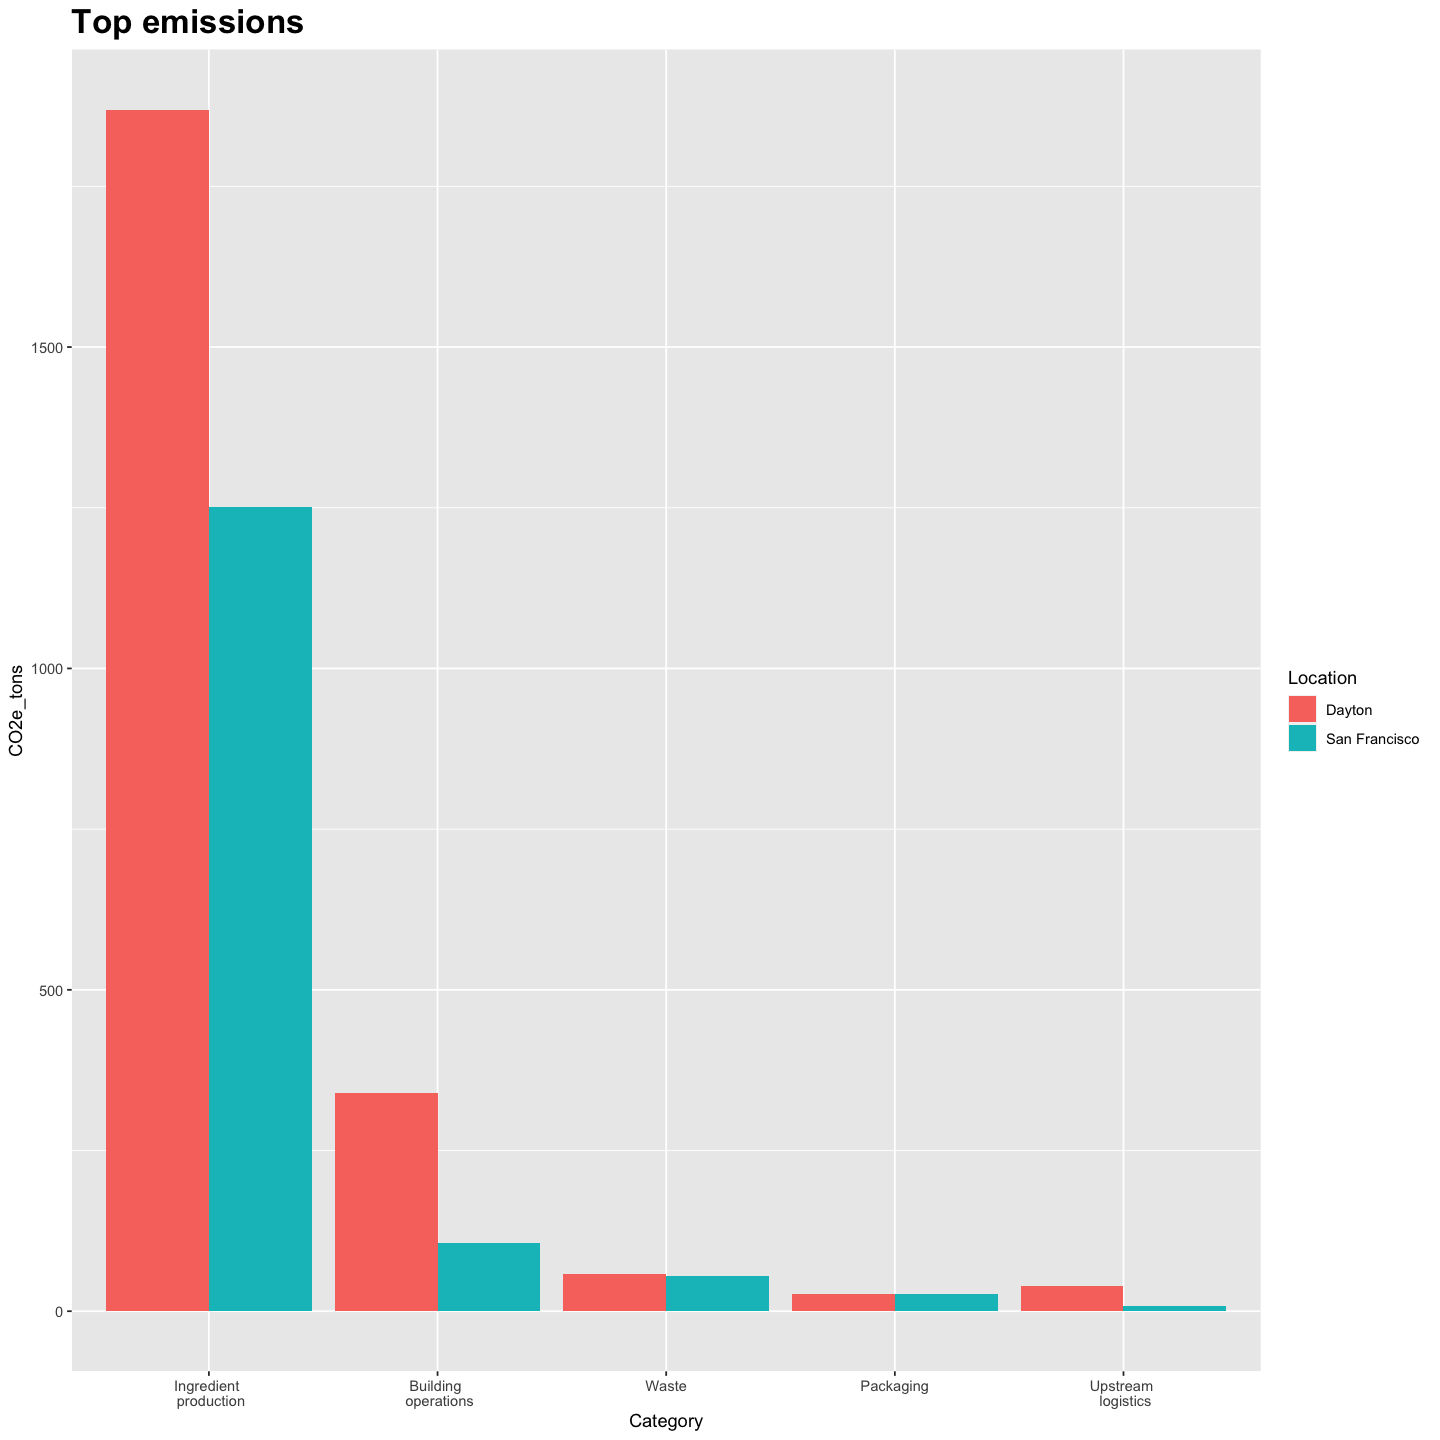

In [9]:
category_chart <- clean_footprint %>% 
  mutate_at(column_names, create_factor) %>% 
  mutate(Category=recode(Category,`Building operations`='Building \n operations',`Ingredient production`='Ingredient \n production',`Upstream logistics`='Upstream \n logistics')) %>% 
  group_by(Category, Location) %>% 
  summarize(CO2e_tons = sum(CO2e_tons)) %>% 
  ggplot(aes(x=reorder(Category, -CO2e_tons), y=CO2e_tons, fill=Location)) +
  geom_col(position='dodge') +
  ggtitle('Top emissions') +
  xlab('Category') +
  theme(plot.title = element_text(size=20,face='bold'))

category_chart

### Ingredients drivers
Let's zoom in on the top category, Ingredient production

`summarise()` has grouped output by 'Description'. You can override using the `.groups` argument.



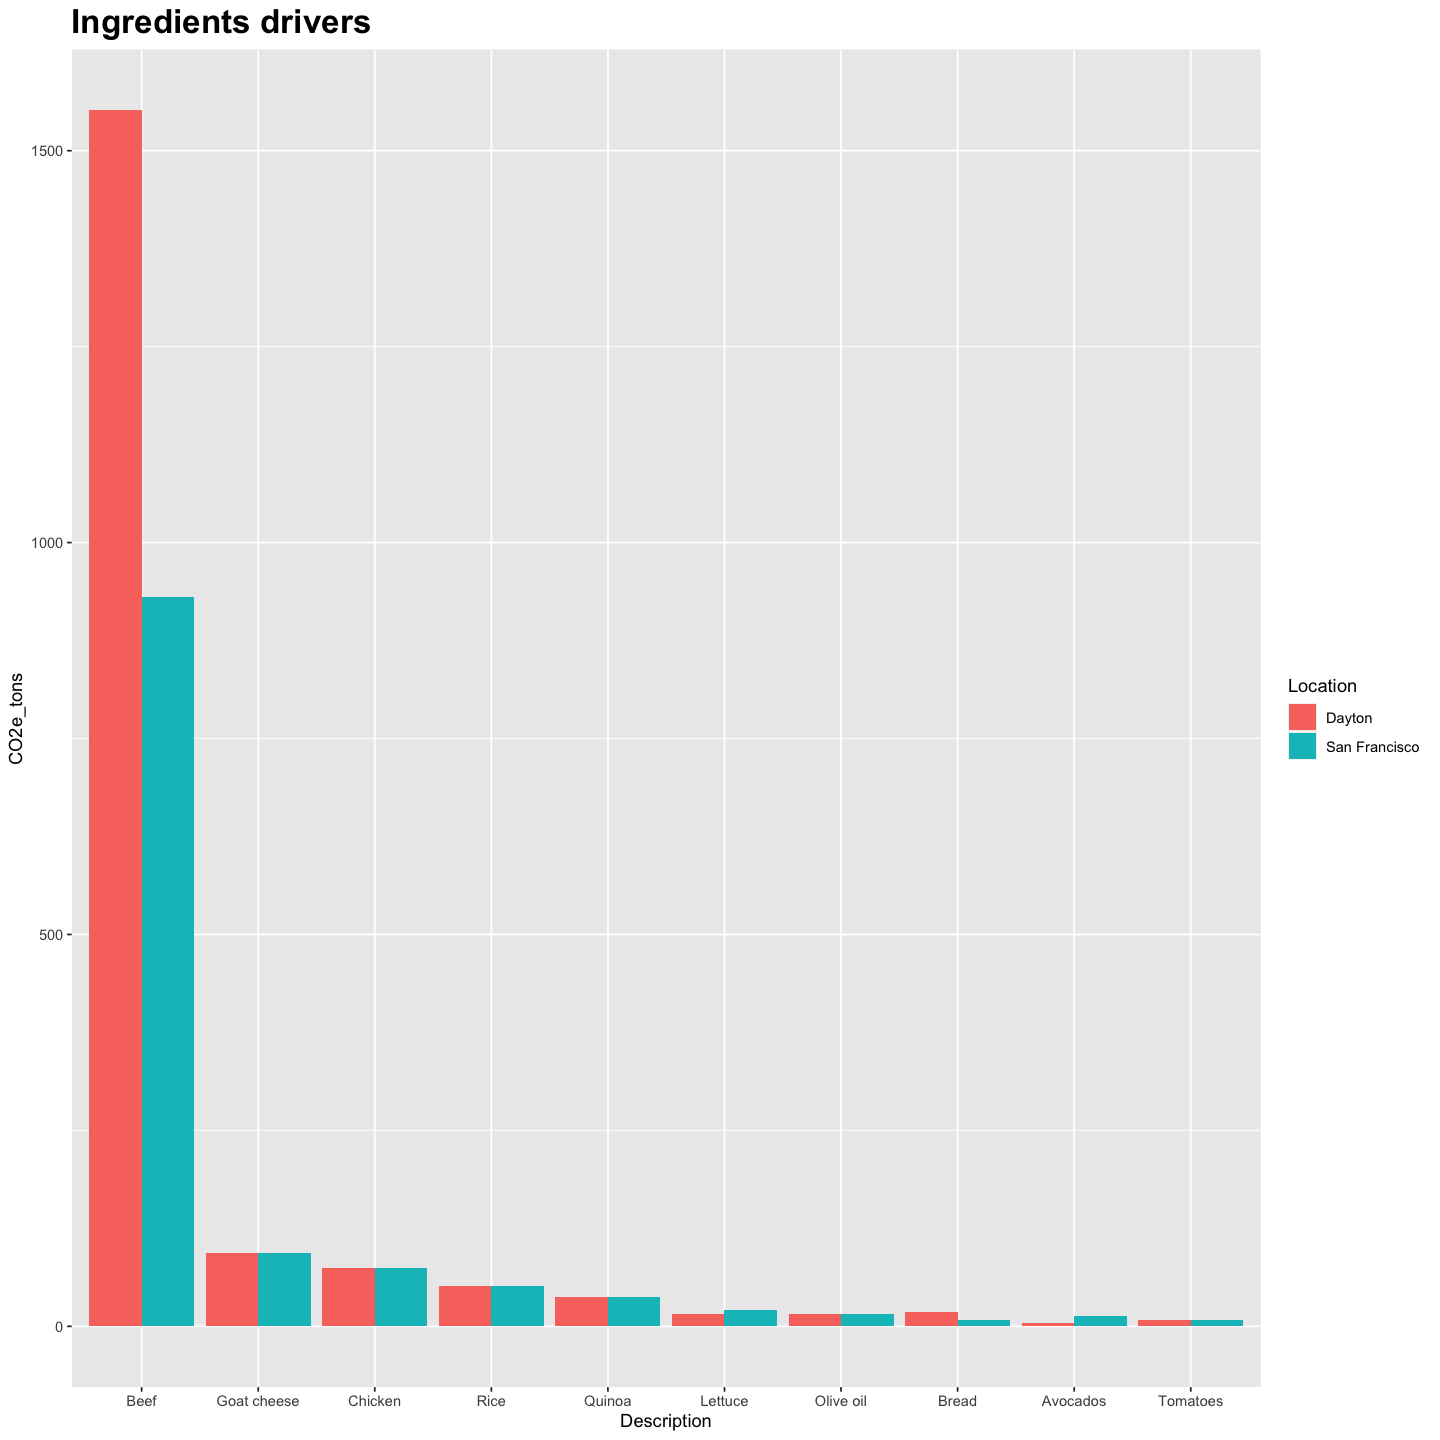

In [10]:
ingredient_chart <- clean_footprint %>% 
  mutate_at(column_names, create_factor) %>% 
  filter(Category=='Ingredient production') %>% 
  group_by(Description, Location) %>% 
  summarize(CO2e_tons = sum(CO2e_tons)) %>% 
  ggplot(aes(x=reorder(Description, -CO2e_tons), y=CO2e_tons, fill=Location)) +
  geom_col(position='dodge') +
  ggtitle('Ingredients drivers') +
  xlab('Description') +
  theme(plot.title = element_text(size=20,face='bold'))

ingredient_chart

## Bending the curve

### 1. Lower-carbon Operations
* Optimize energy use through industrial equipment and refrigeration
  + Benchmark energy intensity is (86 kwh/sqft)
  + Dayton store uses 516447.9 kwh / 4010 sqft = 129 kwh/sqft and San Francisco store uses 249530.63 kwh / 3875 sqft = 64 kwh/sqft
  + **Reduction:** we can cut power usage by (129-86)/129 = 33% at the Dayton store by upgrading our kitchen, assuming our upgrades will get us to the benchmark energy intensity
* Invest in clean energy
  + We can buy renewable energy from our utility, but we can't always be confident the RECs we buy are creating additional clean power
  + The highest-impact way to reduce our carbon from power use is to build our own clean energy installations, which would require money and space
  + A green utility program would be easier and have a medium impact. For example, the CleanPowerSF Green plan emits 40 lb CO2e/MWh = 18 kg CO2e/MWh =  0.018 kg CO2e/kwh, compared to 0.24 kg CO2e/kwh in San Francisco and 0.56 CO2e/kwh in Dayton (https://static1.squarespace.com/static/5a79fded4c326db242490272/t/614b63e7ac40b1028a9a8b2f/1632330730082/CleanPowerSF_PCL_2020_SuperGreen_Electronic.pdf)
  + **Reduction:** we can switch to a CleanPowerSF-equivalent program in both San Francisco and Dayton
* Forward-looking: Optimize building materials, including construction and furniture, in new stores

In [11]:
no_action <- clean_footprint %>% 
  mutate(action = 'No action')

optimize_energy <- clean_footprint %>% 
  mutate(action = 'Optimize Energy Use') %>% 
  # Reduce energy use by 34%
  mutate(units_2019 = case_when(Category == 'Building operations' & Description == 'Restaurant electricity' & Location == 'Dayton' ~ 0.67*units_2019,
                                TRUE ~ units_2019)) %>%
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

green_utilities <- optimize_energy %>% 
  mutate(action = 'Green Utility Plan') %>% 
  # Change kg CO2e per kwh to 0.018 using new green utility plan
  mutate(CO2e_per_unit = case_when(Category == 'Building operations' & Description == 'Restaurant electricity' ~ 0.018,                                TRUE ~ CO2e_per_unit)) %>% 
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

lower_operations_analysis <- no_action %>% 
  rbind(optimize_energy) %>% 
  rbind(green_utilities) %>%
  filter(Category=='Building operations') %>% 
  group_by(Location, action) %>% 
  summarize(`CO2e_tons from operations` = sum(CO2e_tons)) %>% 
  arrange(Location,desc(`CO2e_tons from operations`),desc(action))

lower_operations_analysis

`summarise()` has grouped output by 'Location'. You can override using the `.groups` argument.



Location,action,CO2e_tons from operations
<chr>,<chr>,<dbl>
Dayton,No action,338.72254
Dayton,Optimize Energy Use,242.60189
Dayton,Green Utility Plan,53.67621
San Francisco,Optimize Energy Use,105.59266
San Francisco,No action,105.59266
San Francisco,Green Utility Plan,50.33380


### 2. Food sourcing
* Explore lower-emissions suppliers
  + Where do our current suppliers sit on the carbon curve for their industry? (Nemecek and Poore 2021)
    + For beef (kg CO2e): mean = ~50, median = ~30, Midwest Meat Inc = Oregon Meat Inc = 52
    + For cheese (kg CO2e): mean = ~12, median = ~8, Wisconsin Cheese = Point Reyes Cheese = 18.6
  + We can work with our suppliers to implement emissions best practices, or shift to suppliers lower on the carbon curve
  + **Reduction:** shift to suppliers at the median for beef and cheese, we will cut carbon by (52-30)/52 = 42% for beef and (18.6-8)/18.6 = 57% for cheese
* Closer suppliers
  + Particularly in Dayton, can we cut Upstream Logistics carbon by sourcing from suppliers within 1000km -- for example, by shifting from Point Reyes Cheese to Wisconsin Cheese?
  + For Point Reyes Cheese, the distance to Dayton is 3882 km, so sourcing from Wisconsin Cheese would reduce tonne-kms by 80%
  + For California Organic Farmers, the distance to Dayton is 3872 km, so sourcing from 1000km away would reduce tonne-kms by 74%
  + **Reduction:** shift from Point Reyes Cheese to Wisconsin Cheese (or a lower-emissions supplier in the same region), and from California Organic Farmers to suppliers within 1000km

In [22]:
no_action <- clean_footprint %>% 
  mutate(action = 'No action')

lower_emissions_suppliers <- clean_footprint %>% 
  mutate(action = 'Lower Emissions Suppliers') %>% 
  # Lower beef emissions to the median of 30
  mutate(CO2e_per_unit = case_when(Category == 'Ingredient production' & Description == 'Beef' ~ 30,
                                TRUE ~ CO2e_per_unit)) %>% 
  # Lower cheese emissions to the median of 8
  mutate(CO2e_per_unit = case_when(Category == 'Ingredient production' & Description == 'Goat cheese' ~ 8,
                                   TRUE ~ CO2e_per_unit)) %>% 
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

# Assume we're finding closer suppliers on top of finding lower-emissions suppliers
closer_suppliers <- lower_emissions_suppliers %>% 
  mutate(action = 'Closer Suppliers') %>% 
  # Tonne-km will be 13% of previous totals for these ingredients
  mutate(units_2019 = case_when(Location == 'Dayton' & Category == 'Upstream logistics' & Description %in% c('Tomatoes','Lettuce','Bread','Avocados') ~ units_2019*0.26,
                                TRUE ~ units_2019)) %>% 
  mutate(units_2019 = case_when(Location == 'Dayton' & Category == 'Upstream logistics' & Description == 'Goat cheese' ~ units_2019*0.2,
                                TRUE ~ units_2019)) %>% 
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

food_sourcing_analysis <- no_action %>% 
  rbind(lower_emissions_suppliers) %>% 
  rbind(closer_suppliers) %>%
  filter(Category=='Ingredient production' | Category=='Upstream logistics') %>% 
  group_by(Location, action) %>% 
  summarize(`CO2e_tons from ingredients` = sum(CO2e_tons)) %>% 
  arrange(Location,desc(`CO2e_tons from ingredients`),desc(action))

food_sourcing_analysis

`summarise()` has grouped output by 'Location'. You can override using the `.groups` argument.



Location,action,CO2e_tons from ingredients
<chr>,<chr>,<dbl>
Dayton,No action,1909.0549
Dayton,Lower Emissions Suppliers,1204.4549
Dayton,Closer Suppliers,1178.3014
San Francisco,No action,1259.2091
San Francisco,Lower Emissions Suppliers,815.2491
San Francisco,Closer Suppliers,815.2491


### 3. Menu development
* Shift to a more plant-rich food mix
  + The San Francisco store can be a model for the Dayton store. The two stores have similar revenue, but Dayton sold 30 tons of beef compared to 18 tons in San Francisco, and 40 tons of lettuce compared to 52 tons in San Fracisco
  + How could the Dayton store approach San Francisco's sales mix?
    + Replace some burger options with salad options
    + Consider emphasizing lower-meat alternatives, like a burger bowl or a chicken burger
    + **Reduction:** Dayton store can get halfway to a San Francisco-like sales mix, decreasing beef by 6 tons (20%) and increasing lettuce by 6 tons (15%)
  + Shift a further 10% of beef served to a plant-based meat alternative
    + Impossible Burgers use 3.5 kg CO2e, compared to 50+ kg CO2e for beef (https://impossiblefoods.com/sustainable-food/burger-life-cycle-assessment-2019)
    + **Reduction:** for another 10% of beef, we can shift consumption to Impossible Burgers
* Forward-looking: Add a carbon impact measurement step to menu evaluation

In [23]:
no_action <- clean_footprint %>% 
  mutate(action = 'No action')

reduce_beef <- clean_footprint %>% 
  mutate(action = 'Burgers to Salads in Dayton') %>% 
  # Lower beef consumption by 20% in Dayton; increase lettuce consumption by 15% in Dayton; this will affect ingredient production and upstream logistics
  mutate(units_2019 = case_when(Description == 'Beef' & Location == 'Dayton' ~ 0.8*units_2019,
                                TRUE ~ units_2019)) %>%
  mutate(units_2019 = case_when(Description == 'Lettuce' & Location == 'Dayton' ~ 1.15*units_2019,
                                TRUE ~ units_2019)) %>%
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

impossible_burger <- reduce_beef %>% 
  mutate(action = 'Add Impossible Burger') %>% 
  # For 10% of beef consumption, CO2e is reduced to 6.3% of original value
  mutate(units_2019 = case_when(Category == 'Ingredient production' & Description == 'Beef' ~ 0.9*units_2019 + (0.063*0.1*units_2019),
                                TRUE ~ units_2019)) %>% 
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

menu_development_analysis <- no_action %>% 
  rbind(reduce_beef) %>% 
  rbind(impossible_burger) %>%
  filter(Category=='Ingredient production', Description == 'Beef') %>% 
  group_by(Location, action) %>% 
  summarize(`CO2e_tons from beef` = sum(CO2e_tons)) %>% 
  arrange(Location,desc(`CO2e_tons from beef`),desc(action))

menu_development_analysis

`summarise()` has grouped output by 'Location'. You can override using the `.groups` argument.



Location,action,CO2e_tons from beef
<chr>,<chr>,<dbl>
Dayton,No action,1551.600
Dayton,Burgers to Salads in Dayton,1241.280
Dayton,Add Impossible Burger,1124.972
San Francisco,No action,930.960
San Francisco,Burgers to Salads in Dayton,930.960
San Francisco,Add Impossible Burger,843.729


### 4. Total reduction

In [24]:
no_action <- clean_footprint %>% 
  mutate(action = 'No action')

optimize_energy_total <- clean_footprint %>% 
  mutate(action = 'Optimize Energy Use') %>% 
  # Reduce energy use by 33% in Dayton
  mutate(units_2019 = case_when(Category == 'Building operations' & Description == 'Restaurant electricity' & Location == 'Dayton' ~ 0.67*units_2019,
                                TRUE ~ units_2019)) %>%
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

green_utilities_total <- optimize_energy_total %>% 
  mutate(action = 'Green Utility Plan') %>% 
  # Change kg CO2e per kwh to 0.018 using new green utility plan
  mutate(CO2e_per_unit = case_when(Category == 'Building operations' & Description == 'Restaurant electricity' ~ 0.018,                                TRUE ~ CO2e_per_unit)) %>% 
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

lower_emissions_suppliers_total <- optimize_energy_total %>% 
  mutate(action = 'Lower Emissions Suppliers') %>% 
  # Lower beef emissions to the median of 30
  mutate(CO2e_per_unit = case_when(Category == 'Ingredient production' & Description == 'Beef' ~ 30,
                                TRUE ~ CO2e_per_unit)) %>% 
  # Lower cheese emissions to the median of 8
  mutate(CO2e_per_unit = case_when(Category == 'Ingredient production' & Description == 'Goat cheese' ~ 8,
                                   TRUE ~ CO2e_per_unit)) %>% 
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

# Assume we're finding closer suppliers on top of finding lower-emissions suppliers
closer_suppliers_total <- lower_emissions_suppliers_total %>% 
  mutate(action = 'Closer Suppliers') %>% 
  # Tonne-km will be 13% of previous totals for these ingredients
  mutate(units_2019 = case_when(Location == 'Dayton' & Category == 'Upstream logistics' & Description %in% c('Tomatoes','Lettuce','Bread','Avocados') ~ units_2019*0.26,
                                TRUE ~ units_2019)) %>% 
  mutate(units_2019 = case_when(Location == 'Dayton' & Category == 'Upstream logistics' & Description == 'Goat cheese' ~ units_2019*0.2,
                                TRUE ~ units_2019)) %>% 
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

reduce_beef_total <- closer_suppliers_total %>% 
  mutate(action = 'Burgers to Salads in Dayton') %>% 
  # Lower beef consumption by 20% in Dayton; increase lettuce consumption by 15% in Dayton; this will affect ingredient production and upstream logistics
  mutate(units_2019 = case_when(Description == 'Beef' & Location == 'Dayton' ~ 0.8*units_2019,
                                TRUE ~ units_2019)) %>%
  mutate(units_2019 = case_when(Description == 'Lettuce' & Location == 'Dayton' ~ 1.15*units_2019,
                                TRUE ~ units_2019)) %>%
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

impossible_burger_total <- reduce_beef_total %>% 
  mutate(action = 'Add Impossible Burger') %>% 
  # For 10% of beef consumption, CO2e is reduced to 6.3% of original value
  mutate(units_2019 = case_when(Category == 'Ingredient production' & Description == 'Beef' ~ 0.9*units_2019 + (0.063*0.1*units_2019),
                                TRUE ~ units_2019)) %>% 
  # Calculate kilograms CO2
  mutate(CO2e_kg = (CO2e_per_unit * units_2019)) %>% 
  mutate(CO2e_tons = CO2e_kg/1000)

total_analysis <- no_action %>% 
  rbind(optimize_energy_total) %>% 
  rbind(green_utilities_total) %>% 
  rbind(lower_emissions_suppliers_total) %>% 
  rbind(closer_suppliers_total) %>% 
  rbind(reduce_beef_total) %>% 
  rbind(impossible_burger_total) %>%
  group_by(Location, action) %>% 
  summarize(`Total CO2e_tons` = round(sum(CO2e_tons),1)) %>% 
  # Cheat SF down under Optimize Energy Use scenario so that it appears below "No action"
  mutate(`Total CO2e_tons` = case_when(Location == 'San Francisco' & action == 'Optimize Energy Use' ~ `Total CO2e_tons`-0.1,
                                TRUE ~ `Total CO2e_tons`)) %>% 
  arrange(Location,desc(`Total CO2e_tons`),desc(action))

total_analysis

`summarise()` has grouped output by 'Location'. You can override using the `.groups` argument.



Location,action,Total CO2e_tons
<chr>,<chr>,<dbl>
Dayton,No action,2333.1
Dayton,Optimize Energy Use,2237.0
Dayton,Green Utility Plan,2048.0
Dayton,Lower Emissions Suppliers,1532.4
Dayton,Closer Suppliers,1506.2
Dayton,Burgers to Salads in Dayton,1329.1
Dayton,Add Impossible Burger,1261.6
San Francisco,No action,1446.4
San Francisco,Optimize Energy Use,1446.3
